# Prepare some things
## Load some modules

In [1]:
from tensorflow.keras import models
from tensorflow.keras.datasets import mnist
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

In [2]:
from models import get_autoencoder_model, get_dec_model, get_vae_model, get_clustering_vae_model, get_vade_models
from clustering_metrics import evaluate_model, evaluate_clustering

## Load the MNIST test dataset

In [3]:
_, (x_test, y_test) = (mnist.load_data())
x_test = x_test.reshape(-1, 28*28).astype("float")/255

## Define some parameters

In [4]:
IMG_DIM = 28*28
LATENT_DIM = 10
INTERMEDIATE_DIMS = (512, 512, 2048)
N_CLUSTERS = 10

kmeans = KMeans(n_clusters=N_CLUSTERS, n_init=30)
gmm = GaussianMixture(n_components=N_CLUSTERS, covariance_type='diag', n_init=10)

# Raw data
## K-means

{'Acc': 0.5935,
 'ARI': 0.4087509485822712,
 'AMI': 0.527728584404832,
 'Sil': 0.059361991891680975}

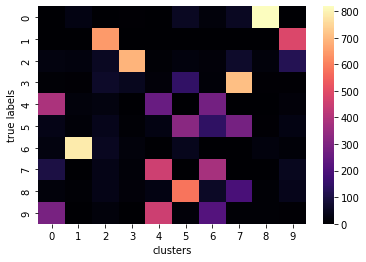

In [5]:
evaluate_clustering(kmeans.fit_predict(x_test), x_test, y_test)

## GMM

{'Acc': 0.4588,
 'ARI': 0.26228771768082265,
 'AMI': 0.36893384012679625,
 'Sil': 0.021388697958098134}

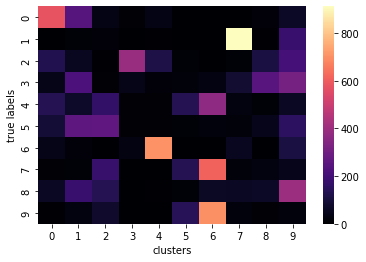

In [6]:
evaluate_clustering(gmm.fit_predict(x_test), x_test, y_test)

# Autoencoder

In [7]:
model_ae = get_autoencoder_model(IMG_DIM, LATENT_DIM, INTERMEDIATE_DIMS)
model_ae.load_weights("model_weights/dec/pretrained/ae")
z = model_ae.encode(x_test)

## K-means on embeddings

{'Acc': 0.8312,
 'ARI': 0.6868013025353379,
 'AMI': 0.7301211964541505,
 'Sil': 0.05290380330749448}

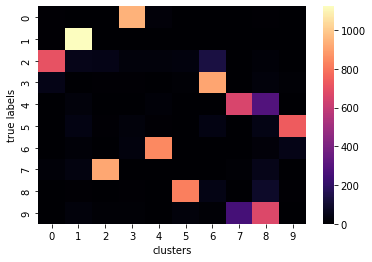

In [8]:
evaluate_clustering(kmeans.fit_predict(z), x_test, y_test)

## GMM on embeddings

{'Acc': 0.6936,
 'ARI': 0.5240824143227197,
 'AMI': 0.6609873521789001,
 'Sil': 0.0048672454179506395}

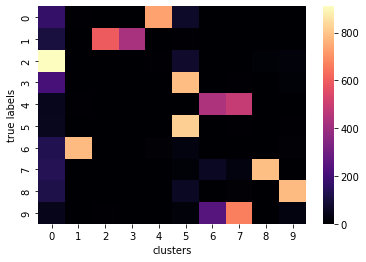

In [9]:
evaluate_clustering(gmm.fit_predict(z), x_test, y_test)

## DEC

{'Acc': 0.8307,
 'ARI': 0.6897532310504929,
 'AMI': 0.735749557666791,
 'Sil': 0.9253225}

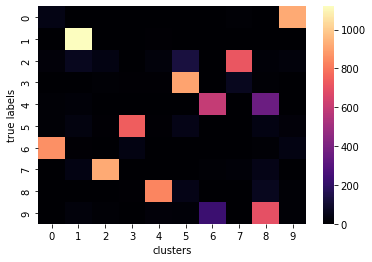

In [10]:
model_dec_kmeans = get_dec_model(model_ae.encoder, N_CLUSTERS)
model_dec_kmeans.load_weights("model_weights/dec/finetuned/dec_kmeans")
evaluate_model(model_dec_kmeans.classify, model_dec_kmeans.encode, x_test, y_test)

{'Acc': 0.7634,
 'ARI': 0.5610876341501859,
 'AMI': 0.6867487443062315,
 'Sil': 0.9341877}

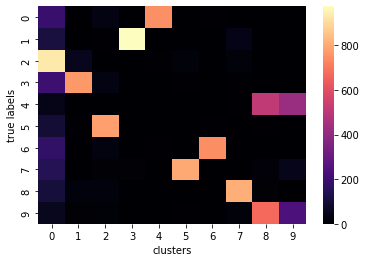

In [11]:
model_dec_gmm = get_dec_model(model_ae.encoder, N_CLUSTERS)
model_dec_gmm.load_weights("model_weights/dec/finetuned/dec_gmm")
evaluate_model(model_dec_gmm.classify, model_dec_gmm.encode, x_test, y_test)

## VAE

In [12]:
model_vae = get_vae_model(IMG_DIM, LATENT_DIM, INTERMEDIATE_DIMS)
model_vae.load_weights("model_weights/cvae/pretrained/vae")
z = model_vae.encode_only_mu(x_test)

## K-means on embeddings

{'Acc': 0.5936,
 'ARI': 0.4114039735783227,
 'AMI': 0.541492800199734,
 'Sil': 0.0362335999891901}

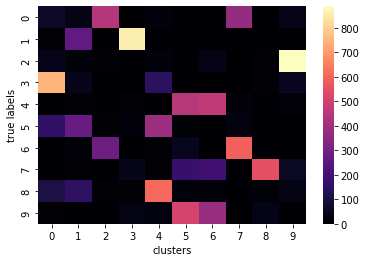

In [13]:
evaluate_clustering(kmeans.fit_predict(z), x_test, y_test)

## GMM on embeddings

{'Acc': 0.5055,
 'ARI': 0.2690167274590122,
 'AMI': 0.41319599241717125,
 'Sil': -0.027637596165403067}

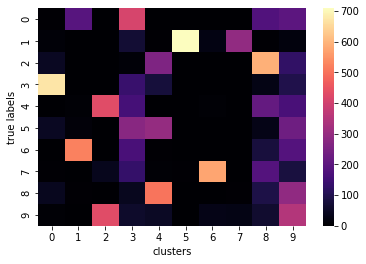

In [14]:
evaluate_clustering(gmm.fit_predict(z), x_test, y_test)

{'Acc': 0.5686,
 'ARI': 0.3724199894429746,
 'AMI': 0.48970122642160796,
 'Sil': 0.20270815}

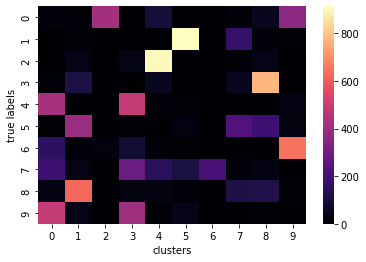

In [15]:
model_cvae_kmeans = get_clustering_vae_model(model_vae, N_CLUSTERS)
model_cvae_kmeans.load_weights("model_weights/cvae/finetuned/cvae_kmeans")
evaluate_model(model_cvae_kmeans.classify, model_cvae_kmeans.encode_only_mu, x_test, y_test)

{'Acc': 0.5856,
 'ARI': 0.353097355916292,
 'AMI': 0.48240546790588074,
 'Sil': 0.12415151}

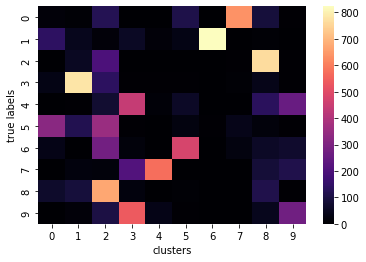

In [16]:
model_cvae_gmm = get_clustering_vae_model(model_vae, N_CLUSTERS)
model_cvae_gmm.load_weights("model_weights/cvae/finetuned/cvae_gmm")
evaluate_model(model_cvae_gmm.classify, model_cvae_gmm.encode_only_mu, x_test, y_test)

## VAE + DEC

{'Acc': 0.6132,
 'ARI': 0.4222826526935391,
 'AMI': 0.5384342740683908,
 'Sil': 0.9043608}

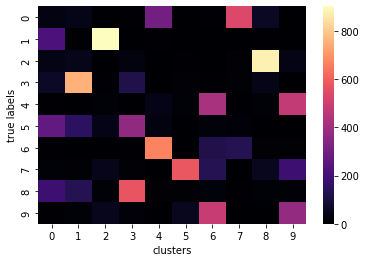

In [17]:
vae_dec_encoder = models.Model(model_vae.encoder.inputs, model_vae.encoder.outputs[0])

model_vae_dec_kmeans = get_dec_model(vae_dec_encoder, N_CLUSTERS)
model_vae_dec_kmeans.load_weights("model_weights/vae_dec/finetuned/dec_kmeans")
evaluate_model(model_vae_dec_kmeans.classify, model_vae_dec_kmeans.encode, x_test, y_test)

{'Acc': 0.569,
 'ARI': 0.3129097737276735,
 'AMI': 0.4690800405814185,
 'Sil': 0.8670885}

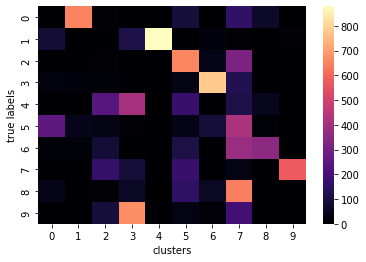

In [18]:
model_vae_dec_gmm = get_dec_model(vae_dec_encoder, N_CLUSTERS)
model_vae_dec_gmm.load_weights("model_weights/vae_dec/finetuned/dec_gmm")
evaluate_model(model_vae_dec_gmm.classify, model_vae_dec_gmm.encode, x_test, y_test)

## VaDE

{'Acc': 0.9414,
 'ARI': 0.8767831631826579,
 'AMI': 0.8759876406345678,
 'Sil': 0.22591504}

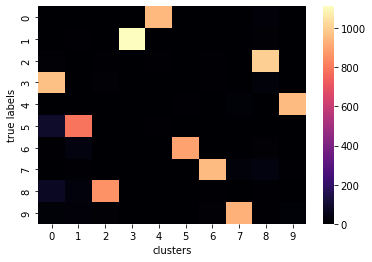

In [19]:
_, model_vade = get_vade_models(N_CLUSTERS, IMG_DIM, LATENT_DIM, INTERMEDIATE_DIMS)
model_vade.load_weights("model_weights/vade/finetuned/vade")
evaluate_model(model_vade.classify, model_vade.encode_only_mu, x_test, y_test)